In [ ]:
!gdown https://drive.google.com/uc?id=13SLUMxU5gUbvGAUCRjWg8539az9dKOzm
!unzip -qq unet.zip

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load images

In [ ]:
PATH = '/content/'
BUFFER_SIZE = 50
BATCH_SIZE = 1
IMG_WIDTH, IMG_HEIGHT = 1024, 256

def load(img_file):
    img = tf.io.read_file(img_file)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img, (IMG_HEIGHT, IMG_WIDTH))

    gray = tf.image.rgb_to_grayscale(tf.identity(img))
    gray = tf.cast(gray, tf.float32)
    color = tf.cast(img, tf.float32)

    return gray, color

def random_jitter(gray, color):
    if tf.random.uniform(()) > 0.5:
        gray = tf.image.flip_left_right(gray)
        color = tf.image.flip_left_right(color)
    return gray, color

def normalize(gray, color): # [-1, 1]
    gray = (gray / 127.5) - 1
    color = (color / 127.5) - 1
    return gray, color

def load_image_train(img_file):
    gray, color = load(img_file)
    gray, color = random_jitter(gray, color)
    return normalize(gray, color)

def load_image_test(img_file):
    gray, color = load(img_file)
    return normalize(gray, color)

In [ ]:
# train_dataset
train_dataset = tf.data.Dataset.list_files(PATH+'kitti_train/*_10.png')
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(1)

# test_dataset
test_dataset = tf.data.Dataset.list_files(PATH+'kitti_test/0000*_10.png')
test_dataset = test_dataset.map(load_image_test)
test_dataset = test_dataset.batch(1)

# Create Model

In [68]:
def extract_first_features(filters, size):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, size, strides=1,
                                    padding = 'same',
                                    kernel_initializer = tf.random_normal_initializer(0., 0.02),
                                    use_bias = False),
         tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])

def downsample(filters, size):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters, size, strides=2, 
                                    padding = 'same',
                                    kernel_initializer = tf.random_normal_initializer(0., 0.02), 
                                    use_bias = False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])

def upsample(filters, size):
    return tf.keras.Sequential([
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding = 'same',
                                    kernel_initializer = tf.random_normal_initializer(0., 0.02),
                                    use_bias = False),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.ReLU()
    ])

In [69]:
def UNet(x):
    down_stack = [
        downsample(64, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4),
        upsample(512, 4),
        upsample(256, 4),
        upsample(64, 4),
    ]

    OUTPUT_CHANNELS = 3
    last_layer = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                         activation='tanh')
    concat = tf.keras.layers.Concatenate()

    # Downsampling through the model
    skips = []
    for down_layer in down_stack:
        x = down_layer(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up_layer, skip in zip(up_stack, skips):
        x = up_layer(x)
        x = concat([x, skip])
    output = last_layer(x)
    
    return output

def Model():
    inputs = tf.keras.layers.Input(shape=(256, 1024, 1))
    x = extract_first_features(64, 3)(inputs)
    outputs = UNet(x)
    return tf.keras.Model(inputs=inputs, outputs=outputs)

In [70]:
optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
model = model = Model()

# Train

In [71]:
def compute_loss(pred_l, target_l): # L1 loss
    return tf.reduce_mean(tf.abs(pred_l - target_l))

def evaluate(model, epoch):
    psnr_mean = 0.0
    count = 0
    for gray, real in test_dataset:
        pred = model([gray], training=True)

        psnr = tf.image.psnr(pred*0.5 + 0.5, real*0.5 + 0.5, max_val=1.0)
        psnr_mean += tf.math.reduce_mean(psnr)
        count = count + 1

    psnr_mean = psnr_mean/count
    print('-------- psnr: ', psnr_mean.numpy(), '   ----- epoch: ', epoch, '  count: ', count)

    return psnr_mean

def generate_images(model, gray, real):
    pred = model([gray], training=True)
    plt.figure(figsize=(15,20))

    display_list = [gray[0,:,:,0], real[0], pred[0]]
    title = ['Input Left', 'Real Left', 'Predicted Left']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [72]:
@tf.function
def train_step(gray, color):
    with tf.GradientTape() as gen_tape:
        pred = model([gray], training=True)
        loss = compute_loss(pred, color)

    generator_gradients = gen_tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(generator_gradients, model.trainable_variables))
    
    return loss    
    
def fit(train_ds, epochs, test_ds):
    best_pnsr = 0.0
    for epoch in range(epochs):  
       
        for gray, color in train_ds:
           loss = train_step(gray, color)
        
        pnsr = evaluate(model, epoch)        
        if best_pnsr < pnsr:
            best_pnsr = pnsr
             
            for gray, color in test_ds.take(1):
                generate_images(model, gray, color)
        #model.save('/content/gdrive/My Drive/data/unet/21.2_{}.h5'.format(epoch+1))

-------- psnr:  21.483488    ----- epoch:  0   count:  100
tf.Tensor(21.483488, shape=(), dtype=float32)


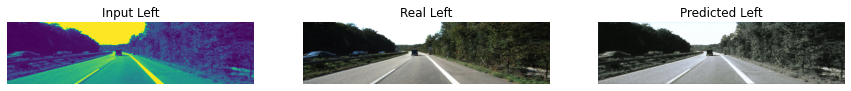

-------- psnr:  22.706367    ----- epoch:  1   count:  100
tf.Tensor(22.706367, shape=(), dtype=float32)


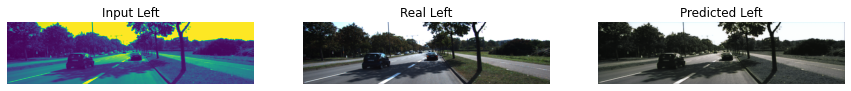

-------- psnr:  23.647993    ----- epoch:  2   count:  100
tf.Tensor(23.647993, shape=(), dtype=float32)


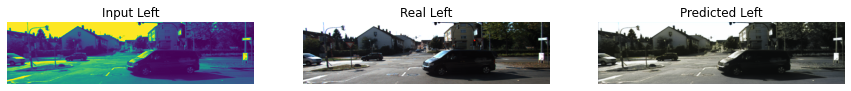

-------- psnr:  23.646528    ----- epoch:  3   count:  100
-------- psnr:  23.924328    ----- epoch:  4   count:  100
tf.Tensor(23.924328, shape=(), dtype=float32)


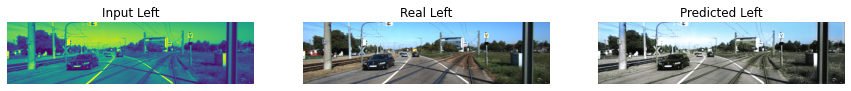

-------- psnr:  23.181324    ----- epoch:  5   count:  100
-------- psnr:  24.044922    ----- epoch:  6   count:  100
tf.Tensor(24.044922, shape=(), dtype=float32)


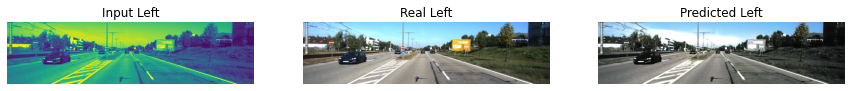

-------- psnr:  24.61001    ----- epoch:  7   count:  100
tf.Tensor(24.61001, shape=(), dtype=float32)


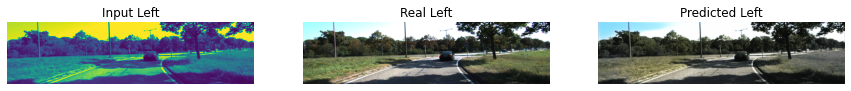

-------- psnr:  24.913094    ----- epoch:  8   count:  100
tf.Tensor(24.913094, shape=(), dtype=float32)


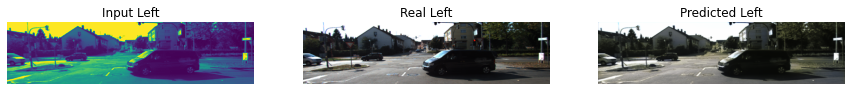

-------- psnr:  24.822454    ----- epoch:  9   count:  100
-------- psnr:  24.95884    ----- epoch:  10   count:  100
tf.Tensor(24.95884, shape=(), dtype=float32)


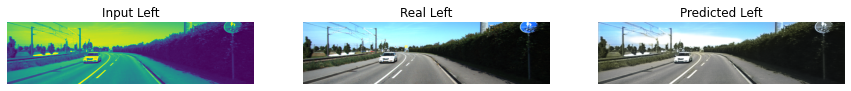

-------- psnr:  24.604649    ----- epoch:  11   count:  100
-------- psnr:  24.686731    ----- epoch:  12   count:  100
-------- psnr:  25.455578    ----- epoch:  13   count:  100
tf.Tensor(25.455578, shape=(), dtype=float32)


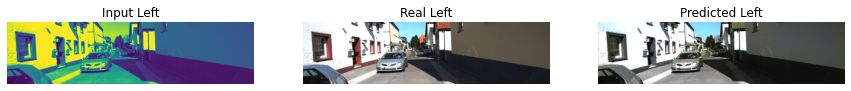

-------- psnr:  24.808002    ----- epoch:  14   count:  100
-------- psnr:  25.165861    ----- epoch:  15   count:  100
-------- psnr:  25.25298    ----- epoch:  16   count:  100
-------- psnr:  25.130142    ----- epoch:  17   count:  100
-------- psnr:  25.544601    ----- epoch:  18   count:  100
tf.Tensor(25.544601, shape=(), dtype=float32)


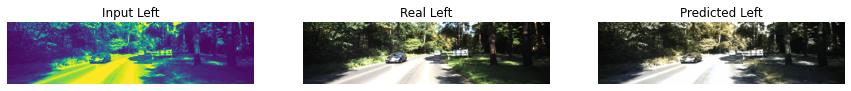

-------- psnr:  25.871984    ----- epoch:  19   count:  100
tf.Tensor(25.871984, shape=(), dtype=float32)


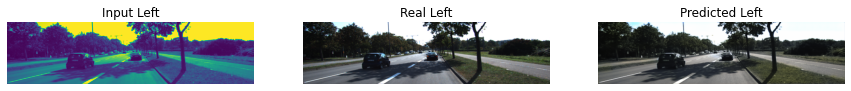

-------- psnr:  25.653109    ----- epoch:  20   count:  100
-------- psnr:  25.61404    ----- epoch:  21   count:  100
-------- psnr:  25.76755    ----- epoch:  22   count:  100
-------- psnr:  25.89795    ----- epoch:  23   count:  100
tf.Tensor(25.89795, shape=(), dtype=float32)


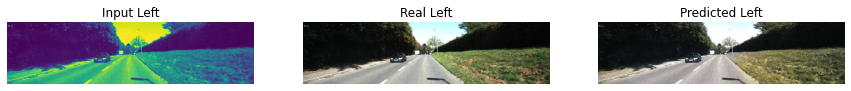

-------- psnr:  25.263786    ----- epoch:  24   count:  100
-------- psnr:  26.053278    ----- epoch:  25   count:  100
tf.Tensor(26.053278, shape=(), dtype=float32)


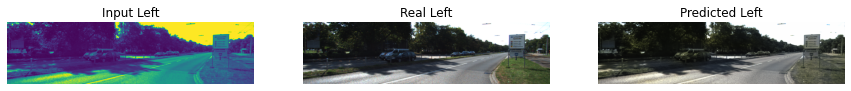

-------- psnr:  25.71555    ----- epoch:  26   count:  100
-------- psnr:  25.679506    ----- epoch:  27   count:  100
-------- psnr:  25.907375    ----- epoch:  28   count:  100
-------- psnr:  26.221128    ----- epoch:  29   count:  100
tf.Tensor(26.221128, shape=(), dtype=float32)


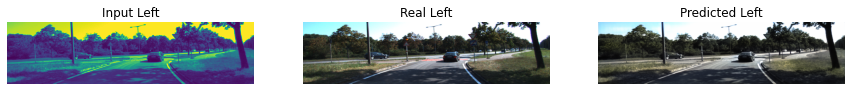

In [73]:
fit(train_ds = train_dataset, 
    epochs = 30, 
    test_ds = test_dataset
)
# new_model = tf.keras.models.load_model('/content/gdrive/My Drive/data/unet/21.2_10.h5')